In [4]:
cd ../../

/mnt/sda/otani/Experiments/moment_retrieval


In [349]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from src.toolbox.eval import _tiou
from src.toolbox.data_converters import Charade2Instances
import pickle as pkl

In [23]:
charade_groundtruth = Charade2Instances(pd.read_csv("data/processed/test.csv"))

In [335]:
data = pd.read_csv("data/raw/AMT/charade-sta/Batch_3991545_batch_results.csv")

In [351]:
len(data)

1500

In [345]:
from scipy.spatial.distance import pdist, squareform

pair_iou = lambda u, v: _tiou(u[None, :], v)

def convertAMTdata2result():
    for _, x in data.groupby("HITId"):
        st_perc = x["Answer.start"]
        ed_perc = x["Answer.end"]
        pred = np.vstack([st_perc, ed_perc]).T
        ious = squareform(pdist(pred, pair_iou))
        ious = ious[~np.eye(ious.shape[0],dtype=bool)].reshape(len(ious), -1)
        index = np.argmax(np.mean(ious, axis=1))
        pred = pred[index]

        video_id = x.iloc[0]["Input.video_url"][:-4]
        description = x.iloc[0]["Input.description"]
        for gt_instance in charade_groundtruth:
            if gt_instance[0] == (video_id, description):
                st_sec, ed_sec, length = gt_instance[1]
                break
        pred = pred / 100 * length
        iou_val = _tiou(pred[None, :], (st_sec, ed_sec))
        res = {'R@1 IoU>0.5': iou_val[0]>.5}
        yield (gt_instance[0], [pred.tolist()+[length]], [1], res)

        
def compute_robust_iou(x):
    st_perc = x["Answer.start"]
    ed_perc = x["Answer.end"]
    video_id = x.iloc[0]["Input.video_url"][:-4]
    description = x.iloc[0]["Input.description"]
    for gt_instance in charade_groundtruth:
        if gt_instance[0] == (video_id, description):
            st_sec, ed_sec, length = gt_instance[1]
            break    
    pred = np.vstack([st_perc, ed_perc]).T  / 100 * length
    ious = squareform(pdist(pred, pair_iou))
    mean_ious = ious.sum(axis=1)/4
    valid_indices = np.argsort(mean_ious)[2:]
    ious = _tiou(pred[valid_indices], (st_sec, ed_sec))
    return ious
    
def compute_iou_at_k(x, k=[0, 1, 2, 3, 4]):
    st_perc = x["Answer.start"]
    ed_perc = x["Answer.end"]
    video_id = x.iloc[0]["Input.video_url"][:-4]
    description = x.iloc[0]["Input.description"]
    for gt_instance in charade_groundtruth:
        if gt_instance[0] == (video_id, description):
            st_sec, ed_sec, length = gt_instance[1]
            break
    pred = np.vstack([st_perc, ed_perc]).T / 100 * length
    ious = _tiou(pred, (st_sec, ed_sec))
    ious = ious[np.argsort(ious)[::-1][k]]
    return ious

def compute_agreement(x):
    st_perc = x["Answer.start"]
    ed_perc = x["Answer.end"]
    pred = np.vstack([st_perc, ed_perc]).T  / 100 * length
    ious = squareform(pdist(pred, pair_iou))
    ious = ious[~np.eye(ious.shape[0],dtype=bool)].reshape(len(ious), -1)
    min_ious = ious.min()
    return min_ious

def compute_iou_with_representative(x):
    st_perc = x["Answer.start"]
    ed_perc = x["Answer.end"]
    pred = np.vstack([st_perc, ed_perc]).T  / 100
    ious = squareform(pdist(pred, pair_iou))
    ious = ious[~np.eye(ious.shape[0],dtype=bool)].reshape(len(ious), -1)
    index = np.argmax(np.mean(ious, axis=1))
    pred = pred[index]
    
    video_id = x.iloc[0]["Input.video_url"][:-4]
    description = x.iloc[0]["Input.description"]
    for gt_instance in charade_groundtruth:
        if gt_instance[0] == (video_id, description):
            st_sec, ed_sec, length = gt_instance[1]
            break
            
    ious = _tiou(pred[None,:]*length, (st_sec, ed_sec))
    return ious

In [350]:
predictions = list(convertAMTdata2result())
pkl.dump(predictions, open("reports/outputs/performance/charade-sta/representative_human.pkl", "wb"))

# Agreement

Text(0.5, 1.0, 'Median min IoU: 0.20')

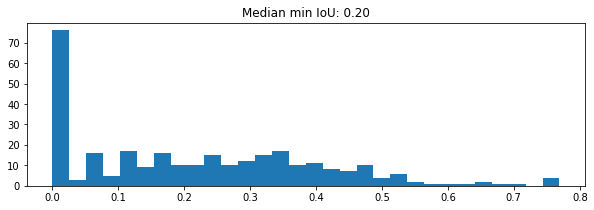

In [332]:
agreement = data.groupby("HITId").apply(compute_agreement).values
plt.figure(figsize=(10, 3))
plt.hist(agreement, bins=30)
plt.title(f"Median min IoU: {np.median(agreement):.2f}")

# IoUs of human annotation

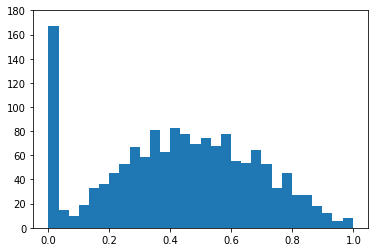

R@1(IoU>0.5):0.413


In [283]:
human_ious = data.groupby("HITId").apply(compute_iou).values
plt.hist(np.hstack(human_ious), bins=30)
plt.ylim([0, 180])
plt.show()
print(f"R@1(IoU>0.5):{np.mean(np.hstack(human_ious) > .5):.3f}")

# IoUs of best human annotation

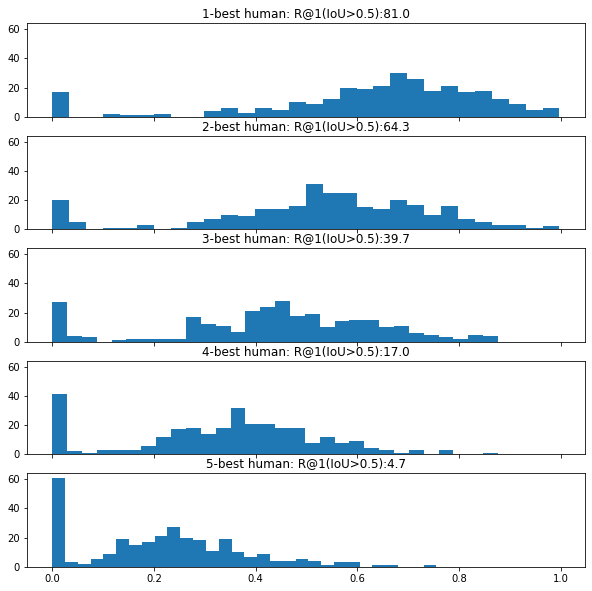

In [339]:
f, axes = plt.subplots(5, 1, figsize=(10, 10), sharex=True, sharey=True)
for ax, k in zip(axes, [0,1,2,3,4]):
    human_ious = data.groupby("HITId").apply(lambda x: compute_iou_at_k(x, k=[k]))
    human_ious = np.hstack(human_ious.values)
    ax.hist(human_ious, bins=30)
    ax.set_title(f"{k+1}-best human: "+f"R@1(IoU>0.5):{np.mean(human_ious > .5)*100:.1f}")

# Performance of Representative Human annotation

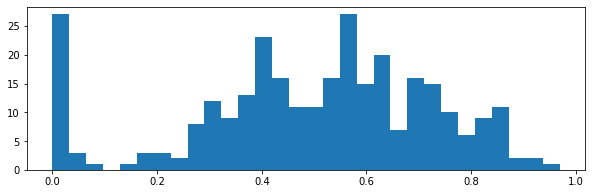

R@1(IoU>0.5):54.0


In [342]:
human_ious = data.groupby("HITId").apply(compute_iou_with_representative).values
plt.figure(figsize=(10, 3))
plt.hist(np.hstack(human_ious), bins=30)
plt.show()
print(f"R@1(IoU>0.5):{np.mean(np.hstack(human_ious) > .5)*100:.1f}")

In [105]:
med_human = human_ious.apply(np.median)
failures = med_human[med_human < 0.5]

In [209]:
data[data["WorkerId"]=="A3N5P5VO81FIJ6"]["HITId"].sample().values[0]

'3OREP8RUU6SWLB0KRQAOCMGL0Q0BGX'

In [314]:
hitid = data["HITId"].sample().values[0]
sample_data = data[data["HITId"] == hitid][["Input.video_url","Answer.start", "Answer.end", "Input.description", "Input.start_sec", "Input.end_sec", "WorkerId"]]
video_id = sample_data["Input.video_url"].values[0]
description = sample_data["Input.description"].values[0]
pred_st = sample_data["Input.start_sec"].values[0]
pred_ed = sample_data["Input.end_sec"].values[0]
for gt_instance in charade_groundtruth:
    if gt_instance[0] == (video_id[:-4], description):
        st_sec, ed_sec, length = gt_instance[1]
sample_data

,Input.video_url,Answer.start,Answer.end,Input.description,Input.start_sec,Input.end_sec,WorkerId
590,BPT87.mp4,27,40,the person laughs.,18.376873,28.586248,A11SX02CICZN85
591,BPT87.mp4,29,39,the person laughs.,18.376873,28.586248,ARTQWWNFA7IOD
592,BPT87.mp4,27,38,the person laughs.,18.376873,28.586248,A1UM7U8DA3RMA9
593,BPT87.mp4,29,44,the person laughs.,18.376873,28.586248,A1NH9LK567B862
594,BPT87.mp4,28,38,the person laughs.,18.376873,28.586248,A272A0JGRTBFCR


In [315]:
from IPython.display import Video
Video(f"http://localhost:8888/files/data/raw/video/{video_id}")

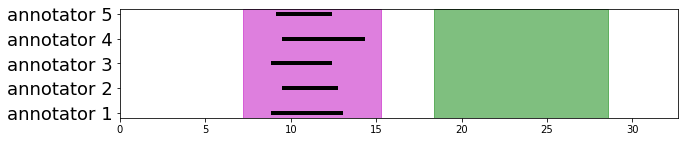

In [318]:
f = plt.figure(figsize=(10, 2))
plt.axvspan(st_sec, ed_sec, color="m", alpha=0.5)
plt.axvspan(pred_st, pred_ed, color="g", alpha=0.5)
plt.xlim([0, length])
plt.yticks([0.2, 0.4, 0.6, 0.8, 1.], [f"annotator {i+1}" for i in range(5)], fontsize=18)

y = 0.2
for _, row in sample_data.iterrows():
    plt.hlines(y, row["Answer.start"] * length/100, row["Answer.end"]*length/100, linewidth=4)
    y += 0.2

In [187]:
failure_data

,Input.video_url,Answer.start,Answer.end,Input.description,Input.start_sec,Input.end_sec,WorkerId
1360,WUTHF.mp4,8,100,one person runs through.,0.0,9.23,A2CKYCHQGXUI10
1361,WUTHF.mp4,6,12,one person runs through.,0.0,9.23,A1FGSZ042NZ694
1362,WUTHF.mp4,6,13,one person runs through.,0.0,9.23,A11SX02CICZN85
1363,WUTHF.mp4,2,14,one person runs through.,0.0,9.23,A1NH9LK567B862
1364,WUTHF.mp4,6,10,one person runs through.,0.0,9.23,A1UM7U8DA3RMA9


In [185]:
data[data["WorkerId"] == "A2CKYCHQGXUI10"]

,HITId,HITTypeId,Title,Description,Keywords,Reward,CreationTime,MaxAssignments,RequesterAnnotation,AssignmentDurationInSeconds,...,Last7DaysApprovalRate,Input.video_url,Input.start_sec,Input.end_sec,Input.length,Input.description,Answer.end,Answer.start,Approve,Reject
160,3OEWW2KGRNSDSLF2T5E2CLDNUX3DOT,35RL0GHNSC9DI5KNV9HVYAFZDHXEGQ,Read a description and mark a corresponding event,Read a description and specify the In and Out ...,"video, annotation",$0.12,Mon Apr 13 01:12:08 PDT 2020,5,BatchId:3991545;OriginalHitTemplateId:920937340;,3600,...,100% (2/2),QUXYH.mp4,19.087502,30.540001,30.54,person seems to be laughing into the blanket.,26,0,NaN,NaN
302,3TZ0XG8CCY1Y43F5A8K4T34XO7K894,35RL0GHNSC9DI5KNV9HVYAFZDHXEGQ,Read a description and mark a corresponding event,Read a description and specify the In and Out ...,"video, annotation",$0.12,Mon Apr 13 01:12:09 PDT 2020,5,BatchId:3991545;OriginalHitTemplateId:920937340;,3600,...,100% (2/2),HG7C2.mp4,0.000000,9.309376,29.79,a person is undressing in the doorway.,49,0,NaN,NaN
477,38Z7YZ2SC7JXL8840W7HSNO013TIQ8,35RL0GHNSC9DI5KNV9HVYAFZDHXEGQ,Read a description and mark a corresponding event,Read a description and specify the In and Out ...,"video, annotation",$0.12,Mon Apr 13 01:12:09 PDT 2020,5,BatchId:3991545;OriginalHitTemplateId:920937340;,3600,...,100% (2/2),QWKVM.mp4,5.773125,15.395000,30.79,person puts a glass on the desk.,23,10,NaN,NaN
515,3AA88CN99TKX05PER99NIP6FSGZKYO,35RL0GHNSC9DI5KNV9HVYAFZDHXEGQ,Read a description and mark a corresponding event,Read a description and specify the In and Out ...,"video, annotation",$0.12,Mon Apr 13 01:12:10 PDT 2020,5,BatchId:3991545;OriginalHitTemplateId:920937340;,3600,...,100% (2/2),IOGR7.mp4,13.291249,22.785000,30.38,person they stand up.,100,74,NaN,NaN
605,30U1YOGZHEDSQD7V0MVBWQNORM6DSQ,35RL0GHNSC9DI5KNV9HVYAFZDHXEGQ,Read a description and mark a corresponding event,Read a description and specify the In and Out ...,"video, annotation",$0.12,Mon Apr 13 01:12:10 PDT 2020,5,BatchId:3991545;OriginalHitTemplateId:920937340;,3600,...,100% (2/2),Z3H4P.mp4,0.000000,7.510000,30.04,person puts some food on a plate.,100,54,NaN,NaN
660,3TRB893CTNR9JZXUE9Y87KUPH09G7G,35RL0GHNSC9DI5KNV9HVYAFZDHXEGQ,Read a description and mark a corresponding event,Read a description and specify the In and Out ...,"video, annotation",$0.12,Mon Apr 13 01:12:19 PDT 2020,5,BatchId:3991545;OriginalHitTemplateId:920937340;,3600,...,100% (2/2),TK1VC.mp4,12.631249,20.209999,20.21,person starts sneezing.,35,3,NaN,NaN
813,3TD33TP5EPJVBKNH5QIEG05I2VNBAL,35RL0GHNSC9DI5KNV9HVYAFZDHXEGQ,Read a description and mark a corresponding event,Read a description and specify the In and Out ...,"video, annotation",$0.12,Mon Apr 13 01:12:19 PDT 2020,5,BatchId:3991545;OriginalHitTemplateId:920937340;,3600,...,100% (2/2),9POJB.mp4,23.535000,31.379999,31.38,person stand up.,100,86,NaN,NaN
894,3S829FDFU6I0MUTUUW1YVY4G618DXY,35RL0GHNSC9DI5KNV9HVYAFZDHXEGQ,Read a description and mark a corresponding event,Read a description and specify the In and Out ...,"video, annotation",$0.12,Mon Apr 13 01:12:11 PDT 2020,5,BatchId:3991545;OriginalHitTemplateId:920937340;,3600,...,100% (2/2),TEV5K.mp4,0.000000,9.556250,30.58,a person opens the window.,21,0,NaN,NaN
895,335VBRURENHFD4PWNB64LD0JZAIE99,35RL0GHNSC9DI5KNV9HVYAFZDHXEGQ,Read a description and mark a corresponding event,Read a description and specify the In and Out ...,"video, annotation",$0.12,Mon Apr 13 01:12:20 PDT 2020,5,BatchId:3991545;OriginalHitTemplateId:920937340;,3600,...,100% (2/2),MKMFK.mp4,0.000000,7.084375,22.67,person drinking out of a cup.,20,0,NaN,NaN
918,3J9UN9O9K795SQNB1GY2PICI1EKJ0N,35RL0GHNSC9DI5KNV9HVYAFZDHXEGQ,Read a description and mark a corresponding event,Read a description and specify the In and Out ...,"video, annotation",$0.12,Mon Apr 13 01:12:11 PDT 2020,5,BatchId:3991545;OriginalHitTemplateId:920937340;,3600,...,100% (2/2),E6DLK.mp4,0.000000,8.515625,27.25,a person sits on a chair.,42,0,NaN,NaN
